In [3]:
pip install pymongo

  Using cached dnspython-2.6.1-py3-none-any.whl.metadata (5.8 kB)
   ---------------------------------------- 0.0/472.9 kB ? eta -:--:--
   -- ------------------------------------ 30.7/472.9 kB 660.6 kB/s eta 0:00:01
   ---------------- ----------------------- 194.6/472.9 kB 2.4 MB/s eta 0:00:01
   -------------------------------------- - 450.6/472.9 kB 3.5 MB/s eta 0:00:01
   ---------------------------------------  471.0/472.9 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 472.9/472.9 kB 2.5 MB/s eta 0:00:00
Using cached dnspython-2.6.1-py3-none-any.whl (307 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Support Vector Classifier for SVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
import spacy
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from pymongo import MongoClient

In [2]:
data = pd.read_csv(r'C:\Users\HP\Desktop\Eitacies\Flirt or Not\FlirtyOrNot.csv', encoding='ISO-8859-1')

In [3]:
data

,Text,Label
0,"Gazing at the stars, I thought of you. The way...",1
1,Hope your day is as awesome as you are!,0
2,"If I were a cat, I'd spend all 9 lives with yo...",1
3,"You're like the best coffee: bold, hot, and im...",1
4,What's on your agenda for today?,0
...,...,...
241,Learning how to (new skill). It's challenging ...,0
242,Finished painting my living room! What do you ...,0
243,Weather is beautiful today. Perfect for a walk...,0
244,Going to the gym later. Want to join me?,0


Pre-processing

Make text to lower case

In [4]:
data['Text'] = data['Text'].str.replace("[^a-zA-Z]", " ",regex=True).str.lower()

Remove stopwords

In [5]:
data['Text'] = data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (ENGLISH_STOP_WORDS)]))

Stemming

In [6]:
stemmer = PorterStemmer()
data['Text'] = data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

Lemmatization

In [7]:
!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 326.8 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.8 MB 798.9 kB/s eta 0:00:16
     - -------------------------------------- 0.5/12.8 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 0.9/12.8 MB 3.4 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 4.7 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 5.2 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 6.2 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 6.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 7.1 MB/s eta 0:00:02
     ------------ --------------------------- 3.9/12.8 MB 7.6 MB/s eta 

In [8]:
data['Text'] = data['Text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

TF-IDF with n-gram

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(data['Text']).toarray()
y = data['Label'].values

In [10]:
data

,Text,Label
0,gaze star think way light world just cosmic,1
1,hope day awesom,0
2,cat d spend live human m just hope amaz date,1
3,like good coffe bold hot imposs resist let s g...,1
4,s agenda today,0
...,...,...
241,learn new skill s challeng reward,0
242,finish paint live room think appropri,0
243,weather beauti today perfect walk park,0
244,go gym later want join,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

PCA to understand if we have linear or non-linear data

In [12]:
pca = PCA(n_components=2)
X_train_reduced = pca.fit_transform(X_train)

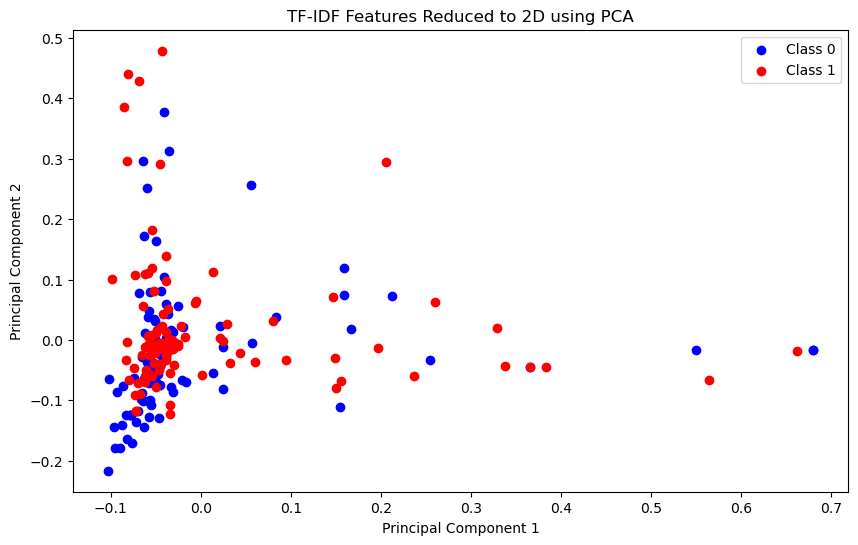

In [13]:
plt.figure(figsize=(10, 6))
for label, color in zip(range(2), ('blue', 'red')):
    plt.scatter(X_train_reduced[y_train == label, 0],
                X_train_reduced[y_train == label, 1],
                label=f'Class {label}',
                color=color)

plt.title('TF-IDF Features Reduced to 2D using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Naive Bayes

In [14]:
MNB_model = MultinomialNB()

In [15]:
MNB_model.fit(X_train, y_train)

MultinomialNB()

Grid Search for Single Naive Bayes

In [16]:
alphas = np.logspace(-2, 1, 20)
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(estimator=MNB_model, param_grid=param_grid, n_jobs=-1, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Alpha: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Alpha:  {'alpha': 0.12742749857031335}
Best Score:  0.8573076923076923


In [17]:
best_mnb = MultinomialNB(alpha=grid_search.best_params_['alpha'])
best_mnb.fit(X_train, y_train)

MultinomialNB(alpha=0.12742749857031335)

Evaluation for training data- Single Naive Bayes

In [18]:
y_train_NB_pred = best_mnb.predict(X_train)
accuracy_NB_train = accuracy_score(y_train, y_train_NB_pred)
print(f"Accuracy: {accuracy_NB_train*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_train, /y_train_NB_pred))

Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00       103

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



Evaluation for test set- Single Naive Bayes

In [19]:
y_test_NB_pred = best_mnb.predict(X_test)
accuracy_NB_test = accuracy_score(y_test, y_test_NB_pred)
print(f"Accuracy: {accuracy_NB_test*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_test_NB_pred))

Accuracy: 86.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.82      0.86      0.84        21

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50



Cross Validation for Single Naive Bayes

In [20]:
n_folds = 5

In [21]:
scores_NB = cross_val_score(best_mnb, X, y, cv=n_folds)
print(f"Accuracy scores for each fold: {scores_NB}")
print(f"Mean cross-validation accuracy: {scores_NB.mean():.2f}")
print(f"Standard deviation of cross-validation accuracy: {scores_NB.std():.2f}")

Accuracy scores for each fold: [0.76       0.81632653 0.87755102 0.81632653 0.91836735]
Mean cross-validation accuracy: 0.84
Standard deviation of cross-validation accuracy: 0.05


Bagging classifier as ensemble model for Naive Bayes

In [22]:
base_model = best_mnb
bagging_clf = BaggingClassifier(estimator=base_model, n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)

BaggingClassifier(estimator=MultinomialNB(alpha=0.12742749857031335),
                  random_state=42)

Evaluation for Bagging for Naive Bayes- Train

In [23]:
y_train_NB_bagging = bagging_clf.predict(X_train)
accuracy_NB_bagging_train = accuracy_score(y_train, y_train_NB_bagging)
print(f"Accuracy: {accuracy_NB_bagging_train*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_train, y_train_NB_bagging))

Accuracy: 98.98%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        93
           1       0.99      0.99      0.99       103

    accuracy                           0.99       196
   macro avg       0.99      0.99      0.99       196
weighted avg       0.99      0.99      0.99       196



Evaluation for Bagging for Naive Bayes- Test

In [24]:
y_test_NB_bagging = bagging_clf.predict(X_test)
accuracy_NB_bagging_test = accuracy_score(y_test, y_test_NB_bagging)
print(f"Accuracy: {accuracy_NB_bagging_test*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_test_NB_bagging))

Accuracy: 90.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92        29
           1       0.90      0.86      0.88        21

    accuracy                           0.90        50
   macro avg       0.90      0.89      0.90        50
weighted avg       0.90      0.90      0.90        50



Logistic Regression

In [25]:
LR_model = LogisticRegression(random_state=42, max_iter=1000)
LR_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Grid search for Logistic Regression

In [29]:
'''param_grid = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],  # 'saga' solver supports all penalty types
    'class_weight': [None, 'balanced'],
    'l1_ratio': np.linspace(0, 1, 10)  # Only used with 'elasticnet' penalty
}
grid_search = GridSearchCV(estimator=LR_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Score: ", grid_search.best_score_)'''

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


KeyboardInterrupt: 

Re-training based on grid search result

In [26]:
LR_model = LogisticRegression(
    C=11.288378916846883,
    class_weight=None,  # Explicitly specifying None for class_weight
    l1_ratio=0.1111111111111111,
    penalty='elasticnet',
    solver='saga',
    max_iter=1000,  # Ensuring a high number of iterations for convergence
    random_state=42  # For reproducibility
)
LR_model.fit(X_train, y_train)

LogisticRegression(C=11.288378916846883, l1_ratio=0.1111111111111111,
                   max_iter=1000, penalty='elasticnet', random_state=42,
                   solver='saga')

Evaluation for training data- Logistic Regression

In [27]:
y_train_LR_pred = LR_model.predict(X_train)
accuracy_LR_train = accuracy_score(y_train, y_train_LR_pred)
print(f"Accuracy: {accuracy_LR_train*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_train, y_train_LR_pred))

Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00       103

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



Evaluation for test set- Logistic Regression

In [28]:
y_test_LR_pred = LR_model.predict(X_test)
accuracy_LR_test = accuracy_score(y_test, y_test_LR_pred)
print(f"Accuracy: {accuracy_LR_test*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_test_LR_pred))

Accuracy: 84.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84        29
           1       0.72      1.00      0.84        21

    accuracy                           0.84        50
   macro avg       0.86      0.86      0.84        50
weighted avg       0.88      0.84      0.84        50



Cross Validation for Logistic Regression

In [29]:
scores_LR = cross_val_score(LR_model, X, y, cv=n_folds)
print(f"Accuracy scores for each fold: {scores_LR}")
print(f"Mean cross-validation accuracy: {scores_LR.mean():.2f}")
print(f"Standard deviation of cross-validation accuracy: {scores_LR.std():.2f}")

Accuracy scores for each fold: [0.82       0.81632653 0.91836735 0.85714286 0.87755102]
Mean cross-validation accuracy: 0.86
Standard deviation of cross-validation accuracy: 0.04


Support Vector Machine

In [30]:
SVM_model = SVC(C=0.6,random_state=42,kernel='rbf')
SVM_model.fit(X_train, y_train)

SVC(C=0.6, random_state=42)

Grid search SVM

In [31]:
parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}

In [32]:
grid_search_SVM = GridSearchCV(SVM_model, parameters, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [33]:
grid_search_SVM.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(C=0.6, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [34]:
print("Best parameters:", grid_search_SVM.best_params_)
print("Best score:", grid_search_SVM.best_score_)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best score: 0.8215384615384617


Update the model according to Grid Search

In [35]:
SVM_model = SVC(C=10,random_state=42,kernel='linear',gamma='scale')
SVM_model.fit(X_train, y_train)

SVC(C=10, kernel='linear', random_state=42)

Evaluation for training data- SVM

In [36]:
y_train_SVM_pred = SVM_model.predict(X_train)
accuracy_SVM_train = accuracy_score(y_train, y_train_SVM_pred)
print(f"Accuracy: {accuracy_SVM_train*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_train, y_train_SVM_pred))

Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        93
           1       1.00      1.00      1.00       103

    accuracy                           1.00       196
   macro avg       1.00      1.00      1.00       196
weighted avg       1.00      1.00      1.00       196



Evaluation for test set- SVM

In [37]:
y_test_SVM_pred = SVM_model.predict(X_test)
accuracy_SVM_test = accuracy_score(y_test, y_test_SVM_pred)
print(f"Accuracy: {accuracy_SVM_test*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_test_SVM_pred))

Accuracy: 84.00%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.72      0.84        29
           1       0.72      1.00      0.84        21

    accuracy                           0.84        50
   macro avg       0.86      0.86      0.84        50
weighted avg       0.88      0.84      0.84        50



Cross Validation for SVM

In [38]:
scores_SVM = cross_val_score(SVM_model, X, y, cv=n_folds)
print(f"Accuracy scores for each fold: {scores_SVM}")
print(f"Mean cross-validation accuracy: {scores_SVM.mean():.2f}")
print(f"Standard deviation of cross-validation accuracy: {scores_SVM.std():.2f}")

Accuracy scores for each fold: [0.86       0.75510204 0.91836735 0.85714286 0.87755102]
Mean cross-validation accuracy: 0.85
Standard deviation of cross-validation accuracy: 0.05


In [39]:
unseen_data = pd.read_csv(r'C:\Users\HP\Desktop\Eitacies\Flirt or Not\FlirtyOrNot_Test.csv', encoding='ISO-8859-1')

In [40]:
unseen_data['Text'] = unseen_data['Text'].str.replace("[^a-zA-Z]", " ",regex=True).str.lower()

In [41]:
unseen_data['Text'] = unseen_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (ENGLISH_STOP_WORDS)]))
stemmer = PorterStemmer()
unseen_data['Text'] = unseen_data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
unseen_data['Text'] = unseen_data['Text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

In [42]:
unseen_data_tfidf = tfidf_vectorizer.transform(unseen_data['Text']).toarray()

In [43]:
unseen_data_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Unseen data prediction with Single NB

In [44]:
new_predictions_NB = best_mnb.predict(unseen_data_tfidf)

In [45]:
accuracy_new_predictions_NB = accuracy_score(unseen_data['Label'], new_predictions_NB)
print(f"Accuracy for Single NB: {accuracy_new_predictions_NB*100:.2f}%")
print("\nClassification Report for Single NB:\n", classification_report(unseen_data['Label'], new_predictions_NB))

Accuracy for Single NB: 66.67%

Classification Report for Single NB:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.69      0.69      0.69        16

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



Unseen data prediction with Bagging NB

In [46]:
new_predictions_Bagging_NB = bagging_clf.predict(unseen_data_tfidf)
accuracy_new_predictions_Bagging_NB = accuracy_score(unseen_data['Label'], new_predictions_Bagging_NB)
print(f"Accuracy for Bagging NB: {accuracy_new_predictions_Bagging_NB*100:.2f}%")
print("\nClassification Report for Bagging NB:\n", classification_report(unseen_data['Label'], new_predictions_Bagging_NB))

Accuracy for Bagging NB: 66.67%

Classification Report for Bagging NB:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.69      0.69      0.69        16

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



In [47]:
new_predictions_LR = LR_model.predict(unseen_data_tfidf)

In [48]:
accuracy_new_predictions_LR = accuracy_score(unseen_data['Label'], new_predictions_LR)
print(f"Accuracy: {accuracy_new_predictions_LR*100:.2f}%")
print("\nClassification Report:\n", classification_report(unseen_data['Label'], new_predictions_LR))

Accuracy: 66.67%

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64        14
           1       0.69      0.69      0.69        16

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



In [49]:
new_predictions_SVM = SVM_model.predict(unseen_data_tfidf)

In [50]:
accuracy_new_predictions_SVM = accuracy_score(unseen_data['Label'], new_predictions_SVM)
print(f"Accuracy: {accuracy_new_predictions_SVM*100:.2f}%")
print("\nClassification Report:\n", classification_report(unseen_data['Label'], new_predictions_SVM))

Accuracy: 63.33%

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        14
           1       0.67      0.62      0.65        16

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30



Random Forest classifier

In [51]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)

In [52]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [53]:
rf_predictions = rf_classifier.predict(X_test)

In [54]:
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy}')

Random Forest Accuracy: 0.74


In [55]:
new_predictions_RF = rf_classifier.predict(unseen_data_tfidf)

In [56]:
accuracy_new_predictions_RF = accuracy_score(unseen_data['Label'], new_predictions_RF)
print(f"Accuracy: {accuracy_new_predictions_RF*100:.2f}%")
print("\nClassification Report:\n", classification_report(unseen_data['Label'], new_predictions_RF))

Accuracy: 56.67%

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.21      0.32        14
           1       0.56      0.88      0.68        16

    accuracy                           0.57        30
   macro avg       0.58      0.54      0.50        30
weighted avg       0.58      0.57      0.51        30



In [57]:
#attempted SVM, Random Forest, Logistic Regression, Naive Bayes and other classification algorithms, but no proper result. Skipping to LSTM now

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStoppingx

# Load and preprocess data
data = pd.read_csv(r'C:\Users\HP\Desktop\Eitacies\Flirt or Not\FlirtyOrNot.csv', encoding='ISO-8859-1')
data_backup=data
data['Text'] = data['Text'].str.replace("[^a-zA-Z]", " ", regex=True).str.lower()
data['Text'] = data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (ENGLISH_STOP_WORDS)]))
stemmer = PorterStemmer()
data['Text'] = data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data['Text'] = data['Text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Text'])
sequences = tokenizer.texts_to_sequences(data['Text'])
max_length = max(len(x) for x in sequences)
X = pad_sequences(sequences, maxlen=max_length)
y = data['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=1001, output_dim=50))
model.add(LSTM(units=120, return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Monitor the validation set loss
                               patience=3,          # Number of epochs with no improvement after which training will be stopped
                               verbose=1,           # Verbosity mode
                               mode='min',          # Mode = 'min' because we want to minimize loss; use 'max' for accuracy
                               restore_best_weights=True)  # Restore model weights from the epoch with the best value of the monitored quantity

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=8, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Predict on unseen data
unseen_data = pd.read_csv(r'C:\Users\HP\Desktop\Eitacies\Flirt or Not\FlirtyOrNot_Test.csv', encoding='ISO-8859-1')
unseen_data['Text'] = unseen_data['Text'].str.replace("[^a-zA-Z]", " ", regex=True).str.lower()
unseen_data['Text'] = unseen_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (ENGLISH_STOP_WORDS)]))
unseen_data['Text'] = unseen_data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
unseen_data['Text'] = unseen_data['Text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
sequences_unseen = tokenizer.texts_to_sequences(unseen_data['Text'])
X_unseen = pad_sequences(sequences_unseen, maxlen=max_length)
predictions_unseen = model.predict(X_unseen)
predicted_classes_unseen = (predictions_unseen > 0.5).astype(int).flatten()

# Evaluate predictions on unseen data
accuracy_unseen = accuracy_score(unseen_data['Label'], predicted_classes_unseen)
print(f"Accuracy on unseen data: {accuracy_unseen*100:.2f}%")
print("\nClassification Report on unseen data:\n", classification_report(unseen_data['Label'], predicted_classes_unseen))

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5338 - loss: 0.6924 - val_accuracy: 0.4750 - val_loss: 0.6967
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4750 - loss: 0.6931 - val_accuracy: 0.4750 - val_loss: 0.6913
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5354 - loss: 0.6724 - val_accuracy: 0.5000 - val_loss: 0.6818
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6253 - loss: 0.6101 - val_accuracy: 0.6250 - val_loss: 0.6163
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9255 - loss: 0.3707 - val_accuracy: 0.8250 - val_loss: 0.5135
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9959 - loss: 0.2203 - val_accuracy: 0.7500 - val_loss: 0.5211
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9691 - loss: 0.0903 - val_accuracy: 0.8250 - val_loss: 0.5069
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9945 - loss: 0.0403 - val_accuracy: 0.8500 - val_lo

Insertion into MongoDB

In [71]:

# Connect to the MongoDB, change the connection string per your MongoDB environment
client = MongoClient('mongodb://localhost:27017/')

# Select the database - if it doesn't exist, it will be created automatically
db = client['prediction_results']

# Select the collection
collection = db['text_predictions']

# Assuming 'unseen_data' is your DataFrame containing the texts and their true labels,
# 'new_predictions_NB', 'new_predictions_Bagging_NB', etc., are your model predictions,
# and 'predicted_classes_unseen' contains your LSTM model predictions,
# you can iterate over the DataFrame and insert the results along with LSTM predictions

# Ensure data_backup is indexed in the same way as unseen_data
data_backup = data_backup.reset_index(drop=True)
unseen_data = unseen_data.reset_index(drop=True)

for index in unseen_data.index:
    # Fetch the original text using the current index
    original_text = data_backup.loc[index, 'Text']  # Assuming 'Text' is the column name in data_backup

    # Create a document for MongoDB insertion
    document = {
        "text": original_text,  # Using the fetched original text
        "true_label": int(unseen_data.loc[index, 'Label']),
        "predictions": {
            "naive_bayes": int(new_predictions_NB[index]),
            "bagging_naive_bayes": int(new_predictions_Bagging_NB[index]),
            "logistic_regression": int(new_predictions_LR[index]),
            "svm": int(new_predictions_SVM[index]),
            "random_forest": int(new_predictions_RF[index]),
            "lstm": int(predicted_classes_unseen[index]),  
        }
    }
    # Insert the document into the collection
    collection.insert_one(document)

print("Inserted prediction results into MongoDB.")

Inserted prediction results into MongoDB.
